In [39]:
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
import altair as alt
from altair.expr import datum

In [40]:
# we need to run this line to use Altair in a Jupyter notebook
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [41]:
# Altair raises a MaxRowsError exception when passing a dataset with more than 5000 rows.
ALTAIR_LIMIT = 5000
# The limit of 5000 rows can be disabled with this line
# https://altair-viz.github.io/user_guide/faq.html#maxrowserror-how-can-i-plot-large-datasets
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [42]:
ROOT = os.path.abspath(os.path.pardir)
DB_NAME = 'Pokemon.db'
DB_PATH = os.path.abspath(os.path.join(ROOT, DB_NAME))
PLOTS_PATH = os.path.abspath(os.path.join(ROOT, 'plots'))
print(DB_PATH)
print(PLOTS_PATH)

/home/giacomo/repos/reddit-dataviz-battle-2018-09/Pokemon.db
/home/giacomo/repos/reddit-dataviz-battle-2018-09/plots


In [43]:
COLOR_NON_LEGENDARY = '#d9d9d9'
COLOR_LEGENDARY = '#ffd700'

In [44]:
engine = sa.create_engine(f"sqlite:///{DB_PATH}")

## Heatmap

In [46]:
sql = '''
SELECT * FROM pokemons AS p
'''
df = pd.read_sql(sql, con=engine)
df.columns

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')

In [49]:
df.experience_growth

0      1059860
1      1059860
2      1059860
3      1059860
4      1059860
5      1059860
6      1059860
7      1059860
8      1059860
9      1000000
10     1000000
11     1000000
12     1000000
13     1000000
14     1000000
15     1059860
16     1059860
17     1059860
18     1000000
19     1000000
20     1000000
21     1000000
22     1000000
23     1000000
24     1000000
25     1000000
26     1000000
27     1000000
28     1059860
29     1059860
        ...   
771    1250000
772    1250000
773    1059860
774    1250000
775    1000000
776    1000000
777    1000000
778    1000000
779    1000000
780    1000000
781    1250000
782    1250000
783    1250000
784    1250000
785    1250000
786    1250000
787    1250000
788    1250000
789    1250000
790    1250000
791    1250000
792    1250000
793    1250000
794    1250000
795    1250000
796    1250000
797    1250000
798    1250000
799    1250000
800    1250000
Name: experience_growth, Length: 801, dtype: int64

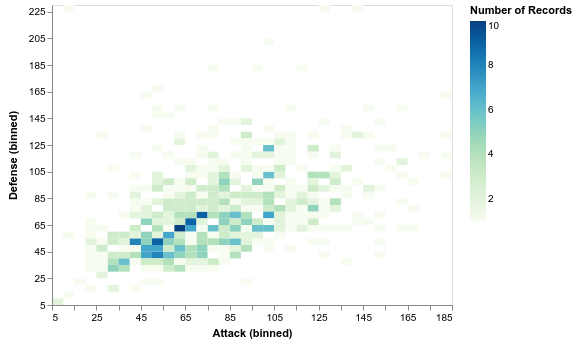

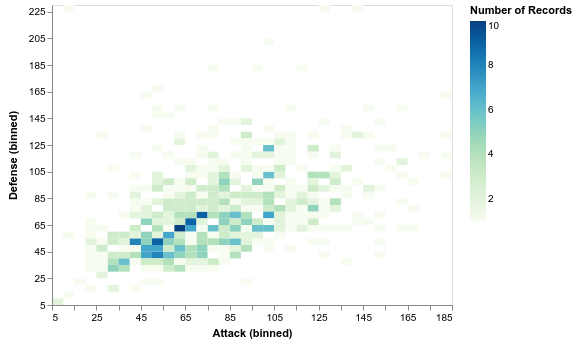

In [8]:
heatmap = alt.Chart(df).mark_rect()\
.encode(
  alt.X('attack:Q', bin=alt.BinParams(step=5), axis=alt.Axis(title='Attack (binned)')),
  alt.Y('defense:Q', bin=alt.BinParams(step=5), axis=alt.Axis(title='Defense (binned)')),
  alt.Color('count(*):Q', scale=alt.Scale(scheme='greenblue'))
)
heatmap

## Barchart

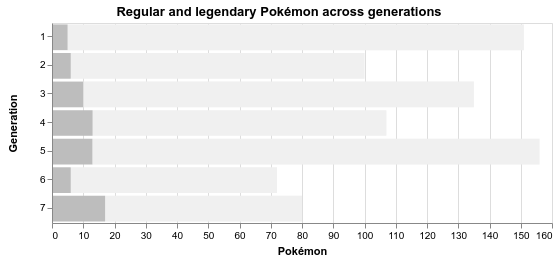

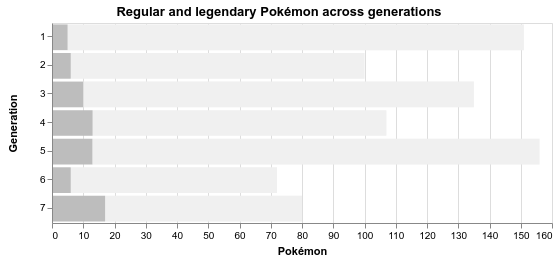

In [21]:
barchart = alt.Chart(df).mark_bar()\
.encode(
  alt.X('count(*):Q', axis=alt.Axis(title='Pokémon')),
  alt.Y('generation:O', axis=alt.Axis(title='Generation')),
  alt.Color('is_legendary:N', scale=alt.Scale(scheme='greys-3'), legend=None)
).properties(width=500, height=200, title='Regular and legendary Pokémon across generations')
barchart

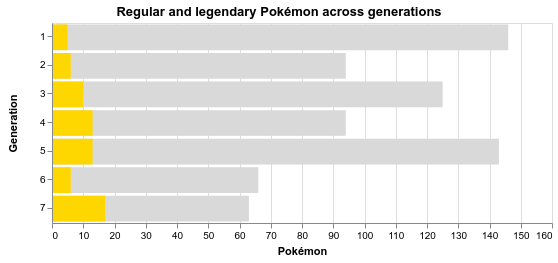

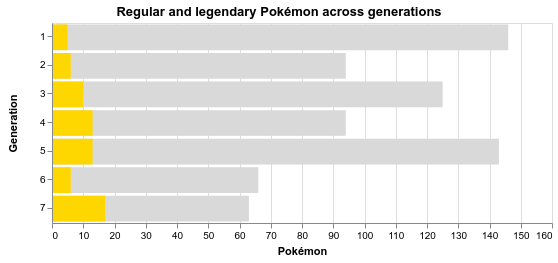

In [22]:
bars0 = alt.Chart(df).mark_bar(color='#d9d9d9')\
.encode(
  alt.X('count(*):Q', axis=alt.Axis(title='Pokémon')),
  alt.Y('generation:O', axis=alt.Axis(title='Generation')),
)\
.transform_filter(datum.is_legendary == 0)

bars1 = alt.Chart(df).mark_bar(color='#ffd700')\
.encode(
  alt.X('count(*):Q', axis=alt.Axis(title='Pokémon')),
  alt.Y('generation:O', axis=alt.Axis(title='Generation'))
)\
.transform_filter(datum.is_legendary == 1)

(bars0 + bars1).properties(width=500, height=200, title='Regular and legendary Pokémon across generations')

## Scatterplot

In [16]:
def make_hcc(row_of_charts):
    hconcat = [chart for chart in row_of_charts]
    hcc = alt.HConcatChart(hconcat=hconcat)
    return hcc

In [17]:
def facet_wrap(charts, charts_per_row):
    rows_of_charts = [charts[i:i+charts_per_row] for i in range(0, len(charts), charts_per_row)]
    vconcat = [make_hcc(r) for r in rows_of_charts]    
    vcc = alt.VConcatChart(vconcat=vconcat)\
      .configure_axisX(grid=False).configure_axisY(grid=True)
    return vcc

In [18]:
def make_base_scatterplot(df, generation, x, y, x_label=None, y_label=None):
    x_label = x_label if x_label is not None else x
    y_label = y_label if y_label is not None else y
    
    fields_in_tooltip = [
        'name', 'japanese_name', 'classfication', 'type1', 'type2',
        'speed', 'height_m', 'weight_kg'
    ]
    
    # avoid numpy datatypes because they are not JSON serializable (and that would be a problem for Vega)
    bottom_x = float(df[x].min())
    top_x = float(df[x].max())
    bottom_y = float(df[y].min())
    top_y = float(df[y].max())
    
    circles_not_legendary = alt.Chart(df).mark_circle(size=60, color='#d9d9d9')\
      .encode(
        x=alt.X(x, axis=alt.Axis(title=x_label, grid=True), scale=alt.Scale(domain=(bottom_x, top_x))),
        y=alt.Y(y, axis=alt.Axis(title=y_label, grid=True), scale=alt.Scale(domain=(bottom_y, top_y))),
        tooltip=fields_in_tooltip
      )\
      .transform_filter(datum.is_legendary == 0)\
      .transform_filter(datum.generation == generation)

    circles_legendary = alt.Chart(df).mark_circle(size=60, color='#ffd700')\
      .encode(
        x=alt.X(x, axis=alt.Axis(title=x_label, grid=True), scale=alt.Scale(domain=(bottom_x, top_x))),
        y=alt.Y(y, axis=alt.Axis(title=y_label, grid=True), scale=alt.Scale(domain=(bottom_y, top_y))),
        tooltip=fields_in_tooltip
      )\
      .transform_filter(datum.is_legendary == 1)\
      .transform_filter(datum.generation == generation)
    
    scatterplot = (circles_not_legendary + circles_legendary)\
      .properties(title=f'Generation {generation}')\
      .interactive()
    return scatterplot

In [19]:
scatterplots = [
    make_base_scatterplot(df, gen, x='attack', y='defense', x_label='Attack', y_label='Defense') 
    for gen in df.generation.unique()]

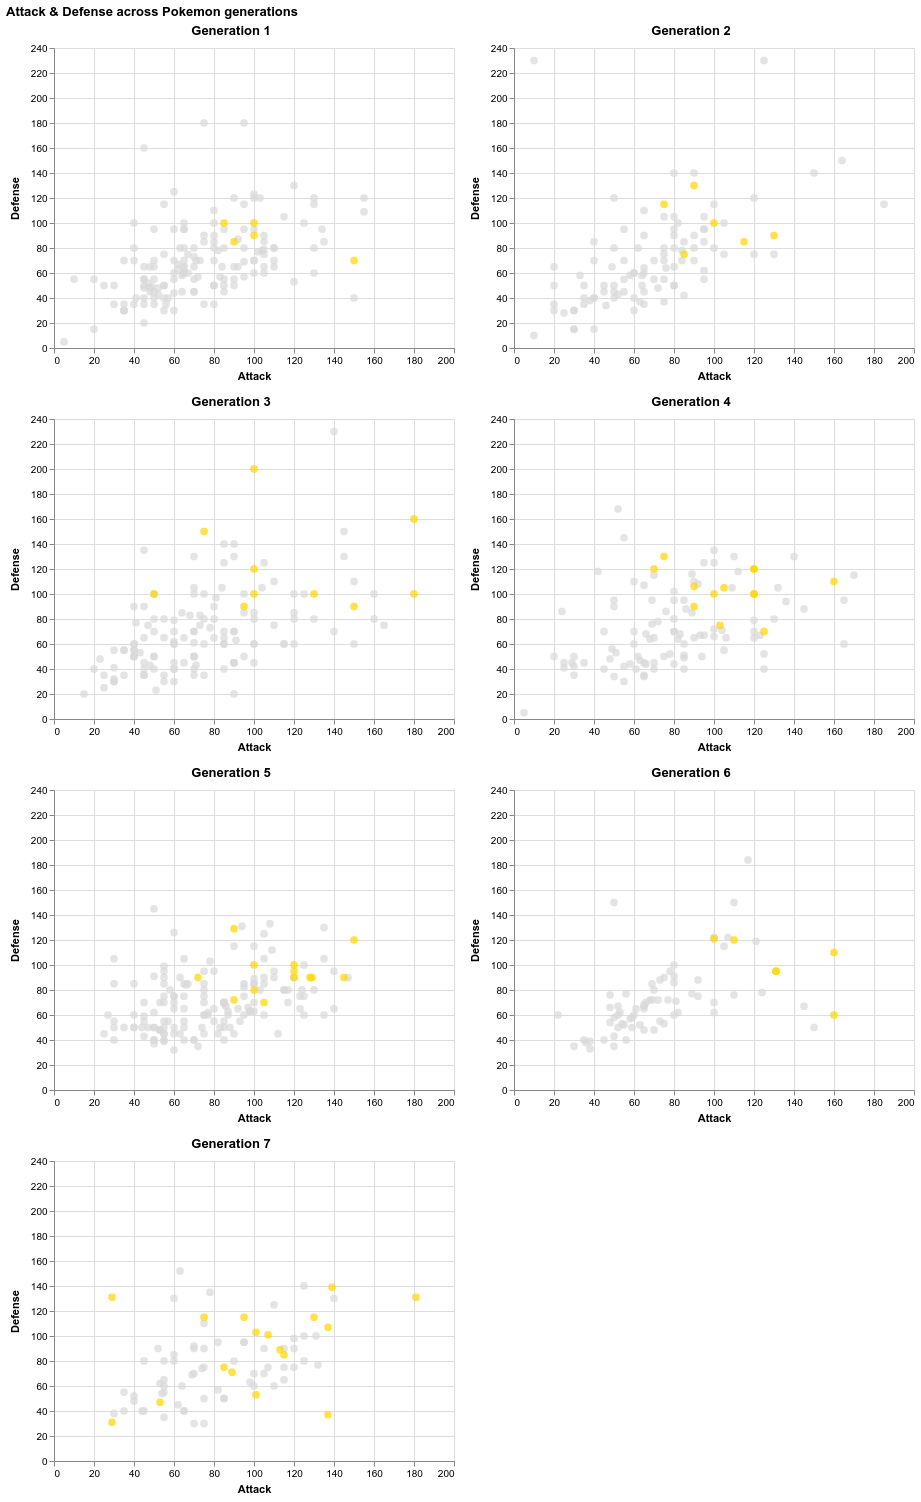

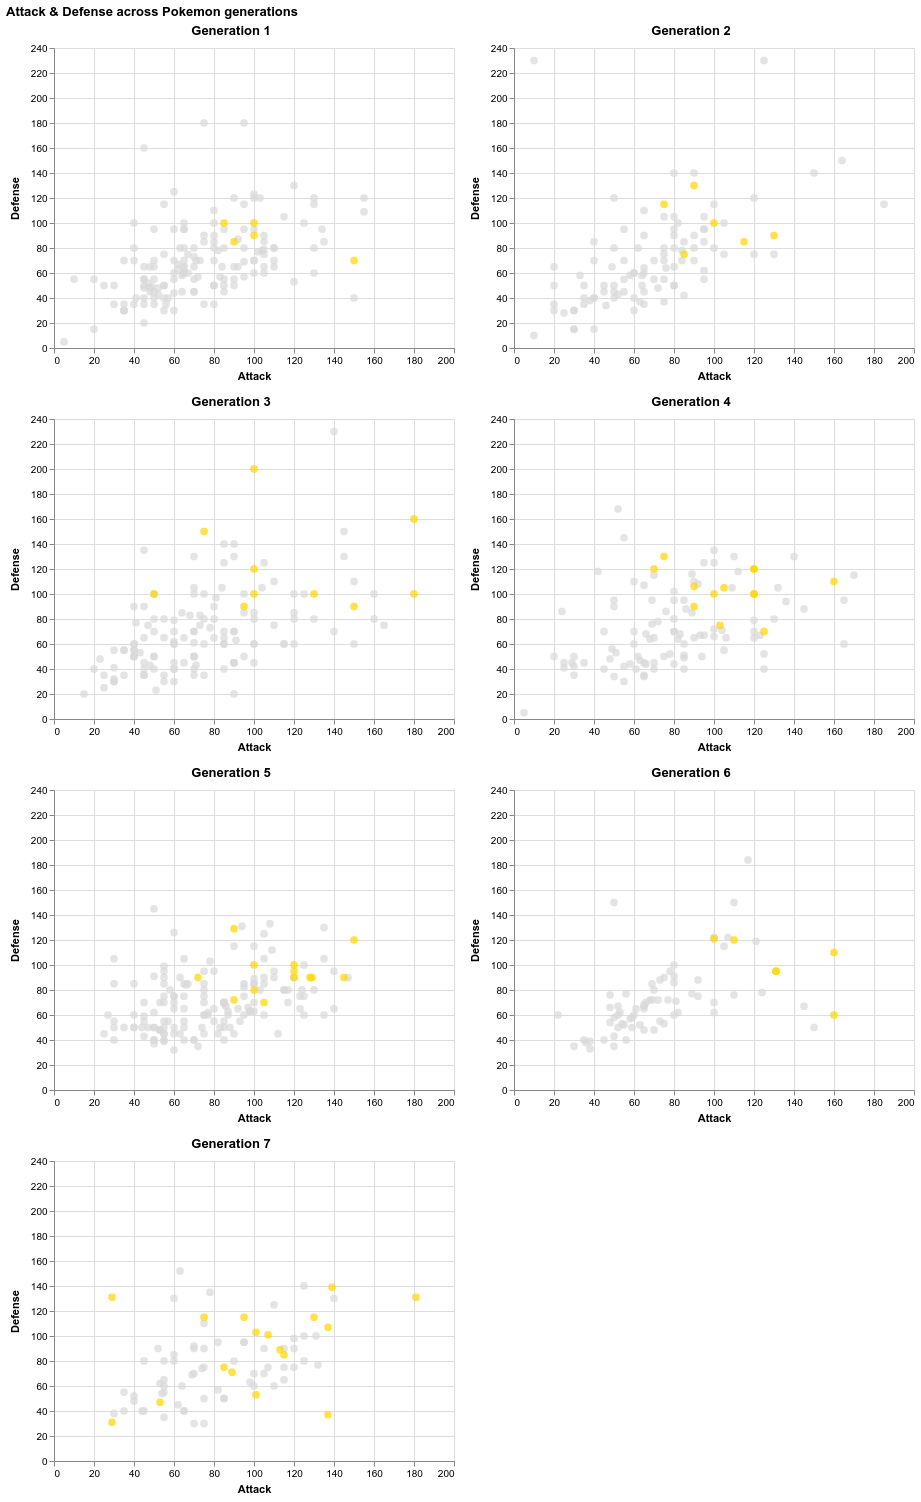

In [20]:
compound_chart = facet_wrap(scatterplots, charts_per_row=2)
compound_chart.properties(title='Attack & Defense across Pokemon generations')

In [24]:
scatterplots = [make_base_scatterplot(df, gen, x='height_m', y='speed') for gen in df.generation.unique()]

In [25]:
compound_chart = facet_wrap(scatterplots, charts_per_row=2)
compound_chart.properties(title=f'{x} & {y} across Pokemon generations')

NameError: name 'x' is not defined

## Box plot

SQLite is [not strong in analytical processing](https://stackoverflow.com/questions/1123576/how-to-find-nth-percentile-with-sqlite#1123642), so we use pandas to prepare the data for a Box plot.

In [26]:
sql = '''
SELECT * FROM pokemons AS p
'''
df = pd.read_sql(sql, con=engine)

In [27]:
def make_box_plot(df, variable, label, options=None):
    if options is None:
        options = {'width': 200, 'height': 250}
    num_generations = len(df.generation.unique())
    
    d = {
        'generation': df.generation.unique().tolist(),
        f'{variable}_min': [df[variable][df.generation == i+1].min() for i in range(num_generations)],
        f'{variable}_q1': [df[variable][df.generation == i+1].quantile(0.25) for i in range(num_generations)],
        f'{variable}_median': [df[variable][df.generation == i+1].quantile(0.5) for i in range(num_generations)],
        f'{variable}_q3': [df[variable][df.generation == i+1].quantile(0.75) for i in range(num_generations)],
        f'{variable}_max': [df[variable][df.generation == i+1].max() for i in range(num_generations)],
    }
    ddf = pd.DataFrame(d)
    ddf['whisker_low'] = ddf.apply(
        lambda r: r[f'{variable}_q1'] - 1.5 * (r[f'{variable}_q3'] - r[f'{variable}_q1']), axis=1)
    ddf['whisker_high'] = ddf.apply(
        lambda r: r[f'{variable}_q3'] + 1.5 * (r[f'{variable}_q3'] - r[f'{variable}_q1']), axis=1)
        
    whisker_low = alt.Chart(ddf).mark_rule(stroke='black', strokeDash=[5, 5])\
    .encode(
      x=alt.X('generation:O', title='Generation'),
      y=alt.Y('whisker_low', title=f'{variable}'.capitalize()),
      y2=f'{variable}_q1'
    )
    
    whisker_high = alt.Chart(ddf).mark_rule(stroke='black', strokeDash=[5, 5])\
    .encode(
      x='generation:O',
      y=f'{variable}_q3',
      y2='whisker_high'
    )
    
    circle_min = alt.Chart(ddf).mark_circle(stroke='black', strokeWidth=1.5, fill='white', size=30)\
    .encode(
      x='generation:O',
      y=f'{variable}_min'
    )
    
    circle_max = alt.Chart(ddf).mark_circle(stroke='black', strokeWidth=1.5, fill='white', size=30)\
    .encode(
      x='generation:O',
      y=f'{variable}_max'
    )
    
    box = alt.Chart(ddf).mark_bar(stroke='black', fill='white', size=10.0)\
    .encode(
      x='generation:O',
      y=f'{variable}_q1',
      y2=f'{variable}_q3',
    )

    tick = alt.Chart(ddf).mark_tick(color='black', size=10.0)\
    .encode(
      x='generation:O',
      y=f'{variable}_median',
    )

    layer_chart = (whisker_low + whisker_high + circle_min + circle_max + box + tick)\
    .properties(width=options['width'], height=options['height'])
    
    return layer_chart

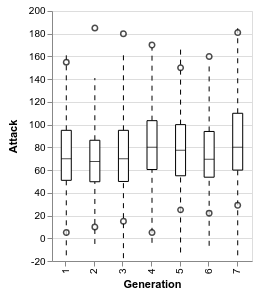

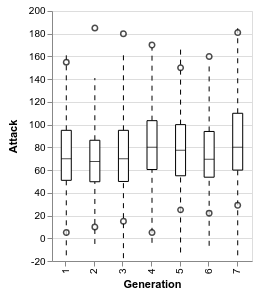

In [28]:
make_box_plot(df, 'attack', label='Attack')

## Line chart

In [31]:
sql = '''
SELECT * FROM pokemons AS p
'''
df = pd.read_sql(sql, con=engine)

In [29]:
def make_line_chart(df, variable, label, options=None):
    if options is None:
        options = {'width': 200, 'height': 250}
    
    line_non_legendary = alt.Chart(df).mark_line(color=COLOR_NON_LEGENDARY)\
    .encode(
      x=alt.X('generation:O', title='Generation'),
      y=alt.Y(f'mean({variable}):Q', title=label)
    )\
    .transform_filter(datum.is_legendary == 0)
    
    
    ci_non_legendary = alt.Chart(df).mark_area(color=COLOR_NON_LEGENDARY, opacity=0.2)\
    .encode(
      x='generation:O',
      y=f'ci0({variable}):Q',
      y2=f'ci1({variable}):Q'
    )\
    .transform_filter(datum.is_legendary == 0)
    
    line_legendary = alt.Chart(df).mark_line(color=COLOR_LEGENDARY)\
    .encode(
      x='generation:O',
      y=f'mean({variable}):Q'
    )\
    .transform_filter(datum.is_legendary == 1)
    
    ci_legendary = alt.Chart(df).mark_area(color=COLOR_LEGENDARY, opacity=0.2)\
    .encode(
      x='generation:O',
      y=alt.Y(f'ci0({variable}):Q'),
      y2=f'ci1({variable}):Q'
    )\
    .transform_filter(datum.is_legendary == 1)
    
    layer_chart = (line_non_legendary + ci_non_legendary + line_legendary + ci_legendary)\
    .properties(width=options['width'], height=options['height'])

    return layer_chart

In [30]:
def make_scatter_plot(df, x, y, x_label, y_label, options=None):
    if options is None:
        options = {'width': 300, 'height': 250}
    
    fields_in_tooltip = [
        'name', 'japanese_name', 'classfication',
        'type1', 'type2',
        'attack', 'defense', 'sp_attack', 'sp_defense', 'hp',
        'speed', 'height_m', 'weight_kg', 'generation'
    ]
    
    # avoid numpy datatypes because they are not JSON serializable (and that would be a problem for Vega)
    bottom_x = float(df[x].min())
    top_x = float(df[x].max())
    bottom_y = float(df[y].min())
    top_y = float(df[y].max())
    
    circles_not_legendary = alt.Chart(df).mark_circle(size=60, color=COLOR_NON_LEGENDARY)\
      .encode(
        x=alt.X(x, axis=alt.Axis(title=x_label, grid=True), scale=alt.Scale(domain=(bottom_x, top_x))),
        y=alt.Y(y, axis=alt.Axis(title=y_label, grid=True), scale=alt.Scale(domain=(bottom_y, top_y))),
        tooltip=fields_in_tooltip
      )\
      .transform_filter(datum.is_legendary == 0)

    circles_legendary = alt.Chart(df).mark_circle(size=60, color=COLOR_LEGENDARY)\
      .encode(
        x=alt.X(x, axis=alt.Axis(title=x_label, grid=True), scale=alt.Scale(domain=(bottom_x, top_x))),
        y=alt.Y(y, axis=alt.Axis(title=y_label, grid=True), scale=alt.Scale(domain=(bottom_y, top_y))),
        tooltip=fields_in_tooltip
      )\
      .transform_filter(datum.is_legendary == 1)
    
    layer_chart = (circles_not_legendary + circles_legendary)\
    .properties(width=options['width'], height=options['height'])
    # .interactive()
    
    return layer_chart

In [32]:
charts = [
    make_line_chart(df, 'attack', label='Attack'),
    make_box_plot(df, 'attack', label='Attck'),
    make_scatter_plot(df, x='hp', y='attack', x_label='HP', y_label='Attack'),
    make_line_chart(df, 'defense', label='Defense'),
    make_box_plot(df, 'defense', label='Defense'),
    make_scatter_plot(df, x='hp', y='defense', x_label='HP', y_label='Defense'),
]

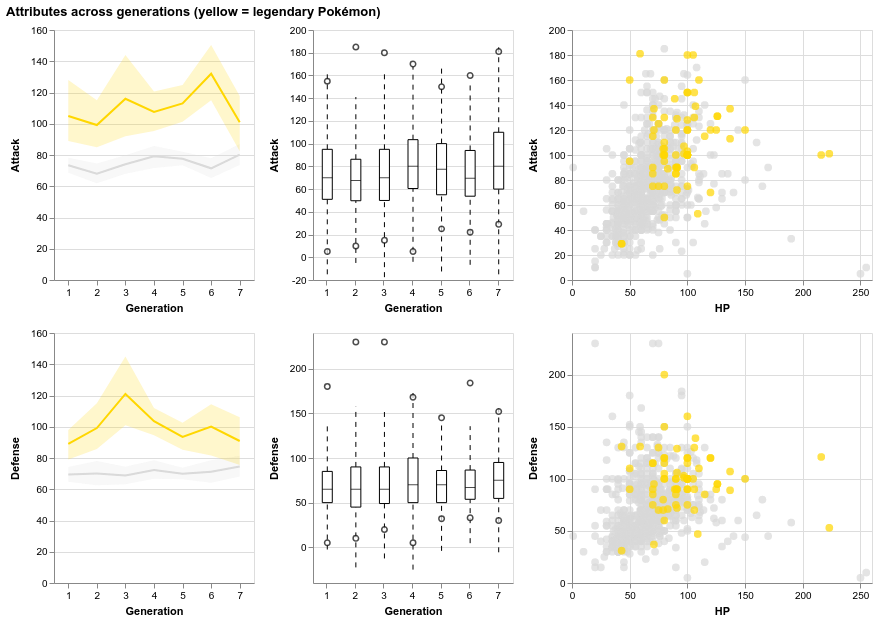

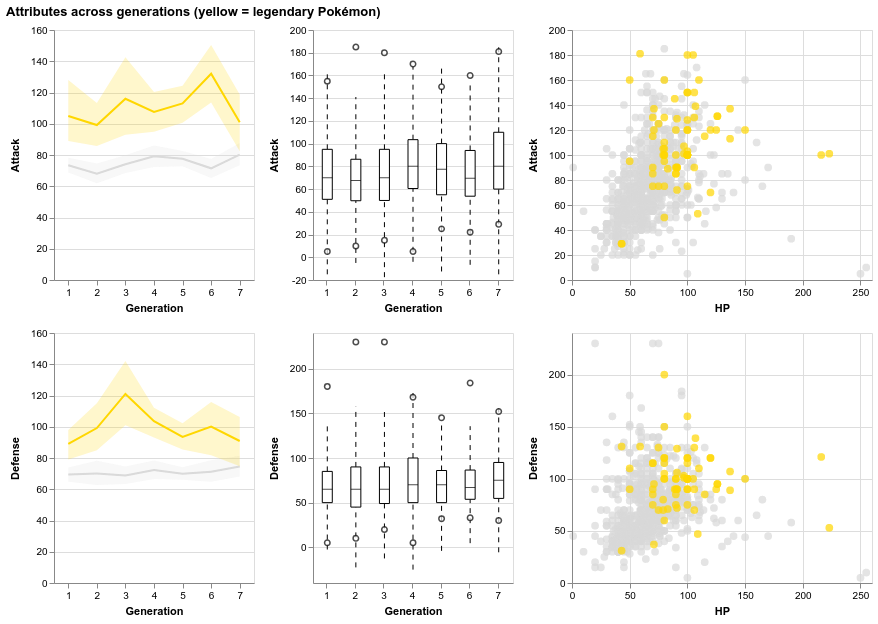

In [33]:
compound_chart = facet_wrap(charts, charts_per_row=3)
compound_chart.properties(title='Attributes across generations (yellow = legendary Pokémon)')\
.configure_axisX(
  domainWidth=1.0,
  labelAngle=0
)

## Multi-line chart

In [34]:
def make_multiline_chart(df):
    df.index.name = 'x'
    data = df.reset_index().melt('x', var_name='attribute_type', value_name='y')
    
    # Create a selection that chooses the nearest point & selects based on x-value
    nearest = alt.selection(
        type='single', nearest=True, on='mouseover', fields=['x'], empty='none')
    
    # https://altair-viz.github.io/user_guide/generated/core/altair.Interpolate.html?highlight=interpolation
    line = alt.Chart().mark_line(interpolate='cardinal')\
      .encode(
        x='x:Q',
        y='y:Q',
        color=alt.Color('attribute_type:N', title='Attribute')
      )
    
    # Transparent selectors across the chart. This is what tells us
    # the x-value of the cursor
    selectors = alt.Chart().mark_point()\
      .encode(
        x='x:Q',
        opacity=alt.value(0),
      )\
      .add_selection(nearest)

    # Draw points on the line, and highlight based on selection
    points = line.mark_point()\
      .encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))
      )

    # Draw text labels near the points, and highlight based on selection
    text = line.mark_text(align='left', dx=5, dy=-5)\
      .encode(
        text=alt.condition(nearest, 'y:Q', alt.value(' '))
      )

    # Draw a rule at the location of the selection
    rules = alt.Chart().mark_rule(color='gray')\
      .encode(
        x='x:Q',
      )\
      .transform_filter(nearest)
    
    # Put the five layers into a chart and bind the data
    layer_chart = alt.layer(line, selectors, points, rules, text, data=data, width=800, height=500)
    return layer_chart

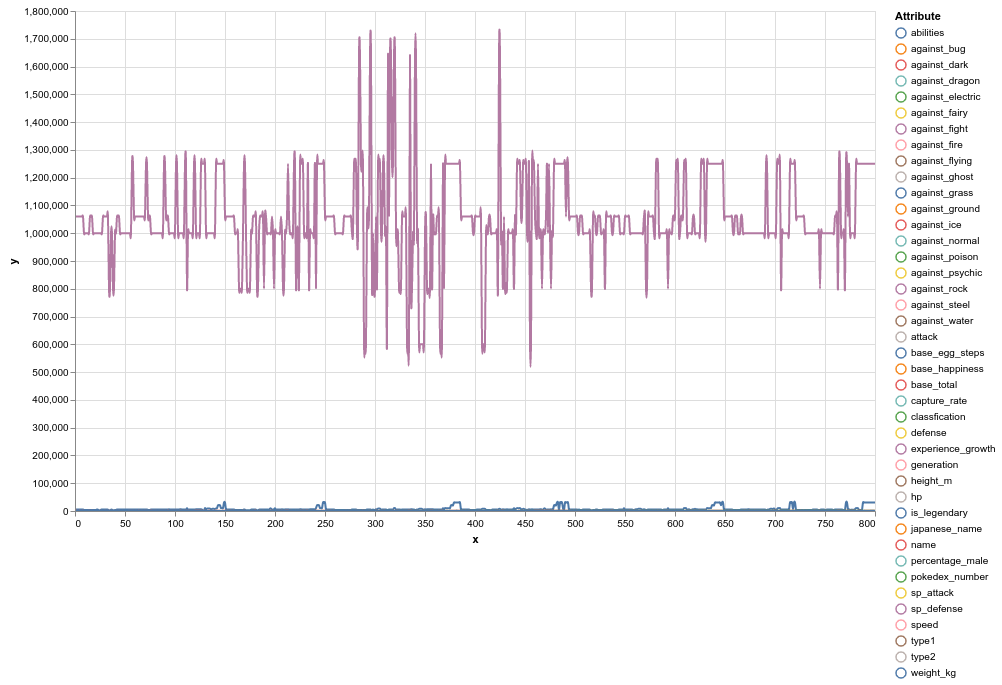

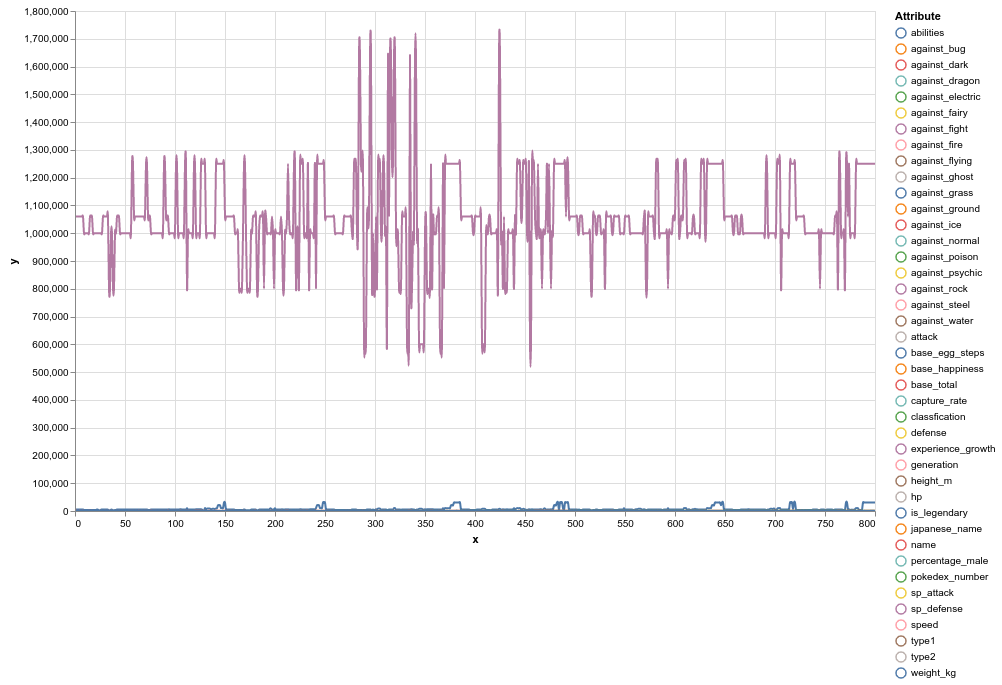

In [35]:
mlc = make_multiline_chart(df)
mlc